In [146]:
import torch
import math
import torch.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [147]:
def i_ERF( q, S):
    a, b, c = -0.2888, -1.769, 1
    a, b, c = torch.tensor(a), torch.tensor(b), torch.tensor(c)

    qb = torch.floor(b / S)
    qc = torch.floor(c/ (a * S ** 2))

    _q = torch.sign(q) * ((torch.min(torch.abs(q), -qb) + qb) ** 2 + qc)

    S_L = a * S**2
    print("ddfd", S_L)
    return _q, S_L

def i_GELU( fp, S):

    q = (fp / S).round()
    q_erf, S_erf = i_ERF(q, S / 1.4142)
    q1 = torch.floor(1 / S_erf)

    _q, _S = q * (q_erf + q1), S * S_erf / 2

    return _q * _S , _S

In [148]:
k = 1.4142
coeff = [-0.2888, -1.769, 1] # a(x+b)**2 + c
coeff[2] /= coeff[0]

def int_erf( x_int, scaling_factor):
    with torch.no_grad():
        b_int = torch.floor(coeff[1] / scaling_factor)
        c_int = torch.floor(coeff[2] / scaling_factor ** 2)

    with torch.no_grad():
        sign = torch.sign(x_int)
    abs_int = torch.abs(x_int)
    abs_int = torch.min(abs_int, -b_int)
    y_int = (abs_int + b_int) ** 2 + c_int
    y_int = sign * y_int
    scaling_factor = scaling_factor ** 2 * coeff[0]
    print("ddfd", scaling_factor)
    
    return y_int, scaling_factor


def INTGELU(x, scaling_factor=None):
    x_int = x / scaling_factor
    x_int = x_int.round()
    sigmoid_int, sigmoid_scaling_factor = int_erf(x_int, scaling_factor / k)

    shift_int = torch.floor(1. / sigmoid_scaling_factor)

    x_int = x_int * (sigmoid_int + shift_int)
    scaling_factor = scaling_factor * sigmoid_scaling_factor / 2
    
    return x_int * scaling_factor, scaling_factor

tensor(-4.4840) tensor(4.2952)


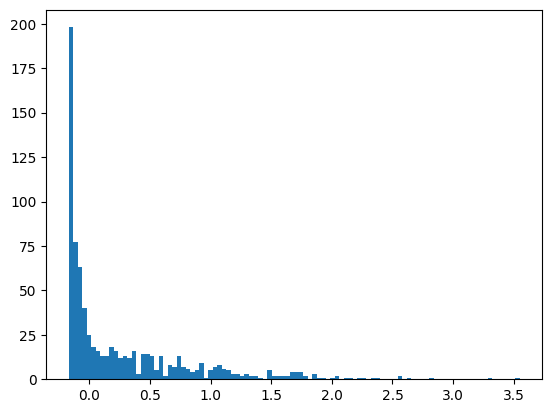

tensor(-0.1700) tensor(4.2952)
tensor(0.0353)
ddfd tensor(-0.0002)
tensor(-0.1685) tensor(4.3080)


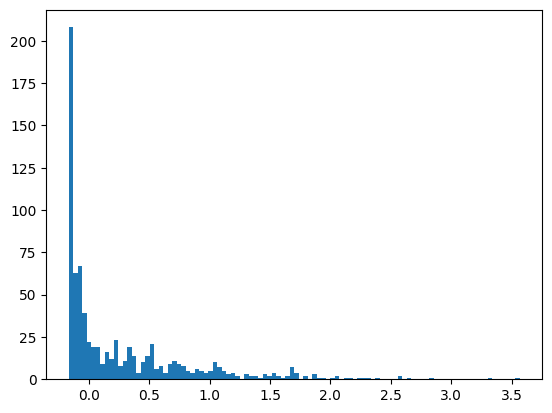

ddfd tensor(-0.0002)
tensor(-0.1685) tensor(4.3080)


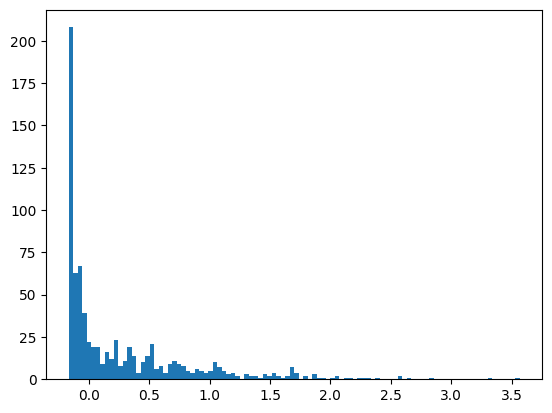

tensor(3.9824)
tensor(3.9824)
tensor(True)


In [149]:
x_fp = torch.randn((1, 197, 768))

print(x_fp.min(), x_fp.max())
# plt.hist(x_fp[0, 0, :].cpu().numpy(), bins=100)
# plt.show()
gelu = nn.GELU()

org_gelu_output = gelu(x_fp)
plt.hist(org_gelu_output[0, 0, :].cpu().numpy(), bins=100)
plt.show()

print(org_gelu_output.min(), org_gelu_output.max())


scaler = x_fp.abs().max() / 127
print(scaler)

myint_gelu_output, _ = i_GELU(x_fp, scaler)
print(myint_gelu_output.min(), myint_gelu_output.max())
plt.hist(myint_gelu_output[0, 0, :].cpu().numpy(), bins=100)
plt.show()

int_gelu_output, _ = INTGELU(x_fp, scaler)
print(int_gelu_output.min(), int_gelu_output.max())
plt.hist(int_gelu_output[0, 0, :].cpu().numpy(), bins=100)
plt.show()

print(torch.norm(org_gelu_output - myint_gelu_output))
print(torch.norm(org_gelu_output - int_gelu_output))
print(torch.eq(myint_gelu_output, int_gelu_output).all())